In [1]:
import numpy as np
import pandas
import os
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import gaussian_kde
import sys
from tqdm import tqdm
import torch

# Set up path to import from src
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")
if src_path not in sys.path:
    sys.path.append(src_path)

# Import pokie from pokie.py
# from new_pokie import pokie, pokie_bootstrap
from pokie import pokie, pokie_bootstrap, get_device, pokie_with_convergence_estimate

In [2]:
curr_num_runs = 100

# Sample from GMM

In [3]:
def generate_samples_from_gmm(means, covariances, n_samples):
    """
    means:       shape (n_components, n_dimensions)
    covariances: shape (n_components, n_dimensions),
                 each row is the diagonal of the covariance matrix for that component
    n_samples:   number of samples to generate in total
    """
    n_components, n_dimensions = means.shape
    samples = np.zeros((n_samples, n_dimensions))
    # Assume uniform mixing weights for simplicity
    component_choices = np.random.choice(
        n_components, size=n_samples, p=np.ones(n_components)/n_components
    )

    for i, comp in enumerate(component_choices):
        # Use np.diag(...) so each component's covariance is diagonal
        cov = np.diag(covariances[comp])
        samples[i, :] = np.random.multivariate_normal(means[comp], cov)
    return samples

# 2 Dimension

In [4]:
# Set up the GMM parameters
n_components = 20
n_dimensions = 2
n_truth_samples = 1000  # Number of ground truth samples
num_posterior_samples = 1000  # Number of posterior samples per truth
epsilon = 1e-3  # Small value to avoid division by zero

# Initialize random means and covariances for the GMM components
means = np.random.rand(n_components, n_dimensions) * 10  # Random means between 0 and 10
covariances = np.random.rand(n_components, n_dimensions) + epsilon  # Ensure strictly positive variance

# Generate the truth data (no shift)
truth_data = generate_samples_from_gmm(means, covariances, n_truth_samples)

# Generate the models with different shift magnitudes from -10 to 10 along the diagonal
shift_magnitudes = np.arange(-10, 11, 1)  # Shift values from -10 to 10  # Shift values from -10 to 10
num_models = len(shift_magnitudes)

print(f'Shift magnitudes: {shift_magnitudes}')

# Generate shifted GMMs once per model
models_base = np.zeros((num_models, num_posterior_samples, n_dimensions))  # Shape: (21, 500, 2)

for i, shift in enumerate(tqdm(shift_magnitudes, desc=f'Generating Shifted GMMs')):
    models_base[i] = generate_samples_from_gmm(means, covariances, num_posterior_samples) + np.ones(n_dimensions) * shift

# Now, expand to (num_models, num_truth_samples, num_posterior_samples, dimensions)
models = np.repeat(models_base[:, np.newaxis, :, :], n_truth_samples, axis=1)

# Validate shape
assert models.shape == (num_models, n_truth_samples, num_posterior_samples, n_dimensions), "Shape mismatch!"

epsilon = 1e-10  # Small value to avoid division by zero

# Get min and max from truth_data (per dimension)
low = np.min(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)
high = np.max(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)

# Normalize truth_data
truth_data_normalized = (truth_data - low) / (high - low + epsilon)

# Normalize models (loop over each shift magnitude)
models_normalized = np.zeros_like(models)
for m_idx in range(num_models):
    models_normalized[m_idx] = (models[m_idx] - low) / (high - low + epsilon)

Shift magnitudes: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]


Generating Shifted GMMs: 100%|██████████| 21/21 [00:00<00:00, 40.78it/s]


In [5]:
# Identify your device (CUDA > MPS > CPU)
device = get_device()
print("Using device:", device)

# Convert to torch Tensors on the chosen device
truth_data_normalized   = torch.tensor(truth_data_normalized, dtype=torch.float32, device=device)
models_normalized = torch.tensor(models_normalized,   dtype=torch.float32, device=device)

results, calibrated, n_over_N_vals = pokie(truth_data_normalized, models_normalized, num_runs=curr_num_runs)

# Convert results, calibrated, n_over_N_vals back to numpy arrays
results = results.cpu().numpy()
calibrated = calibrated.cpu().numpy()
n_over_N_vals = n_over_N_vals.cpu().numpy()

print('\nShift Magnitudes:', shift_magnitudes)
print('Results:', results)
print('Calibrated:', calibrated)

Using device: mps


Pokie MC runs: 100%|██████████| 100/100 [00:01<00:00, 67.49it/s]



Shift Magnitudes: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]
Results: [0.04079065 0.04155823 0.04272523 0.04412868 0.04585291 0.04848589
 0.04923773 0.05096762 0.05241065 0.05275271 0.05264571 0.05195221
 0.05154201 0.05062936 0.04992909 0.04898659 0.04807981 0.04633008
 0.04480277 0.0436136  0.04257846]
Calibrated: [0.51832503 0.5280786  0.54290754 0.5607412  0.58265096 0.616108
 0.6256617  0.64764327 0.66598    0.67032623 0.66896677 0.6601544
 0.65494215 0.6433451  0.6344467  0.6224704  0.6109481  0.58871436
 0.56930685 0.5541962  0.5410427 ]


# 2D GMM Plots

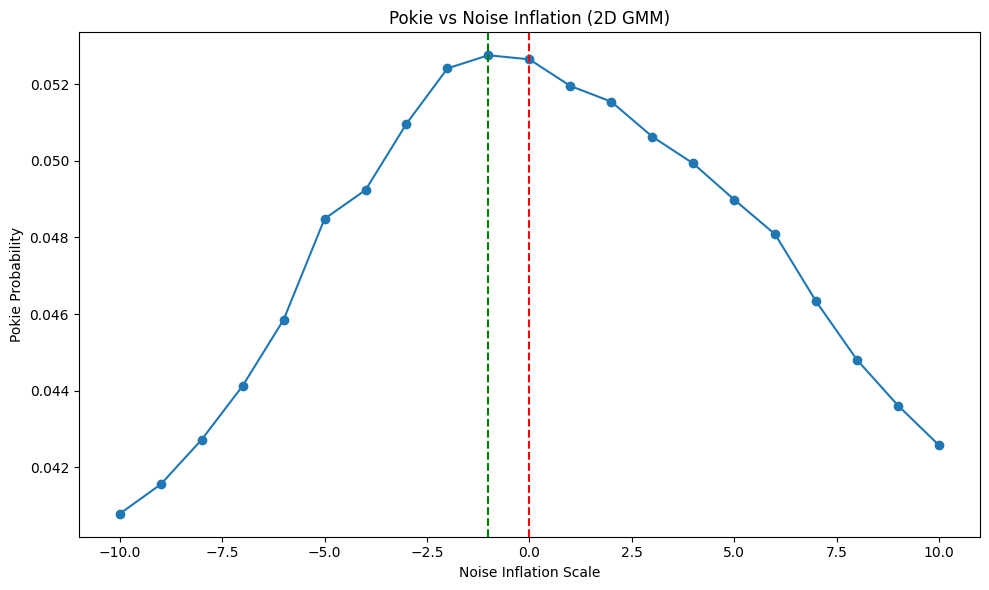

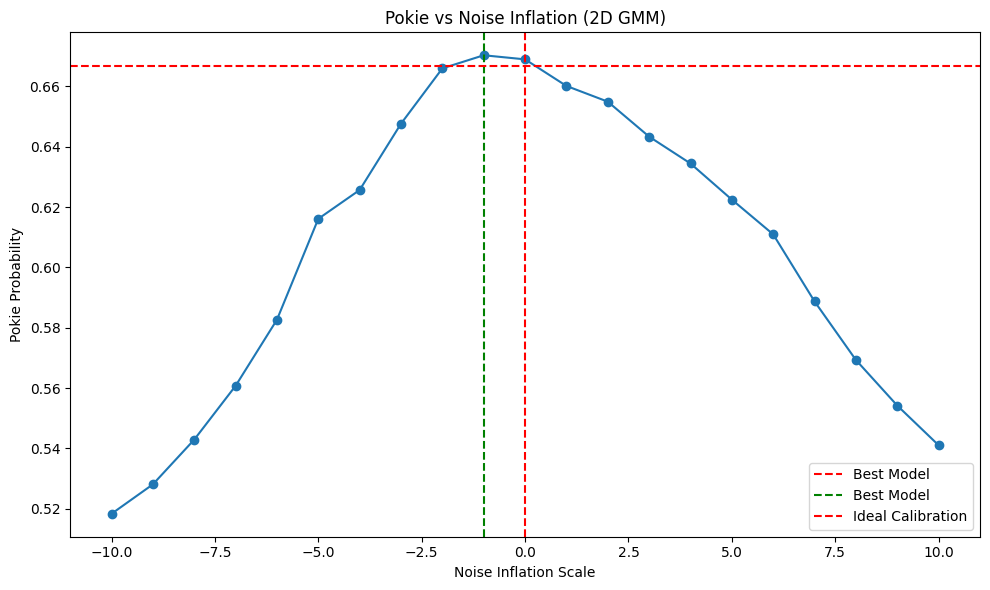

In [ ]:
# Print Index and Value of the best model (i.e. the one with the largest value in results)
best_model_idx = np.argmax(results)
best_model_value = results[best_model_idx]

# Plot Pokie vs noise level
plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, results, marker='o')
plt.axvline(x=0, color='r', linestyle='--', label='Best Model')
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--', label='Best Model')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Pokie vs Noise Inflation (2D GMM)')
plt.tight_layout()
plt.savefig(f"../PLots/GMM/2D/Num_Runs_{curr_num_runs}/Pokie_2D_GMM_Num_Runs_{curr_num_runs}.pdf")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, calibrated, marker='o')
plt.axvline(x=0, color='r', linestyle='--', label='Best Model')
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--', label='Best Model')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Pokie vs Noise Inflation (2D GMM)')
plt.axhline(y=2/3, color='r', linestyle='--', label='Ideal Calibration')
plt.legend()
plt.tight_layout()
plt.savefig(f"../PLots/GMM/2D/Num_Runs_{curr_num_runs}/Pokie_2D_GMM_Calibrated_Num_Runs_{curr_num_runs}.pdf")
plt.show()

# 2 Dimensional n/N Distribution Plots

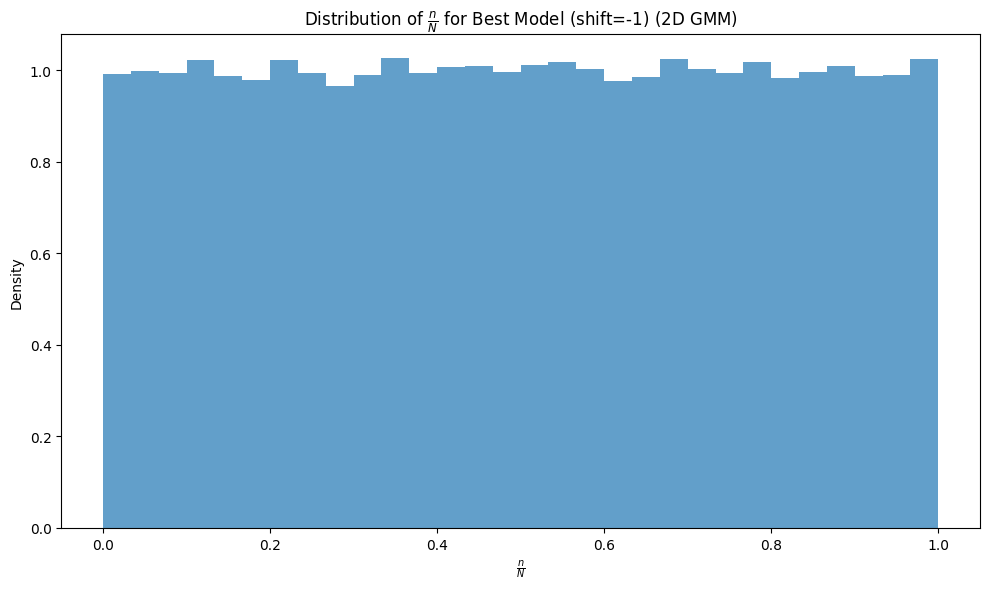

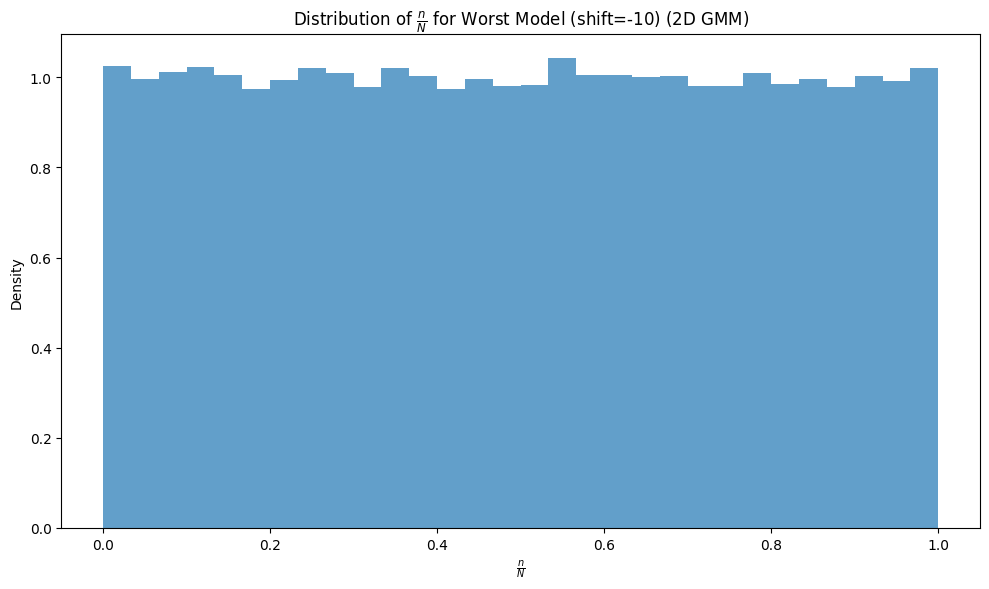

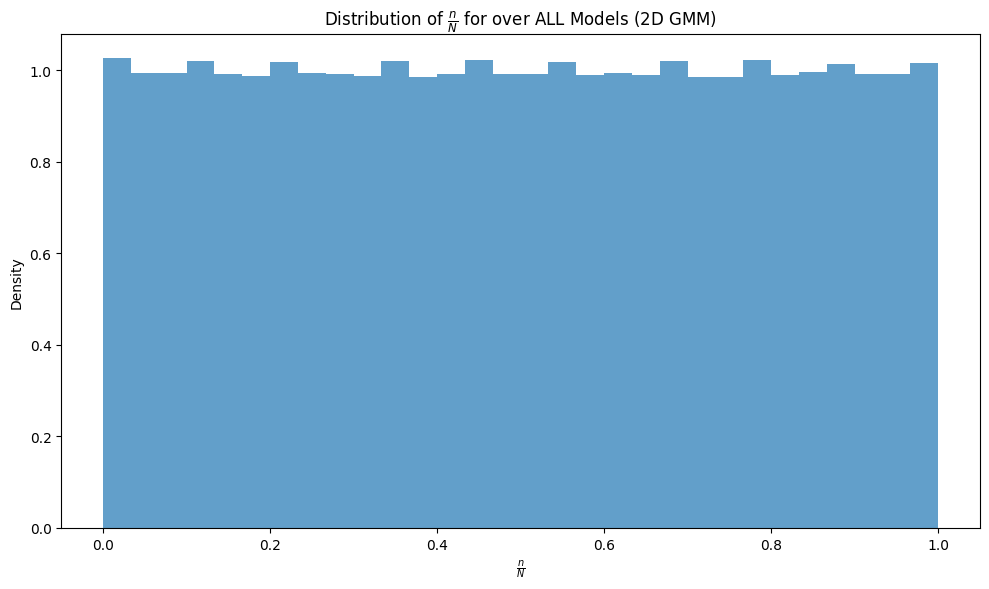

In [ ]:
# Identify the best model
best_model_idx = np.argmax(results)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
best_vals = n_over_N_vals[:, best_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the best model
plt.figure(figsize=(10, 6))
plt.hist(best_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Best Model (shift={shift_magnitudes[best_model_idx]}) (2D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig(f"../PLots/GMM/2D/Num_Runs_{curr_num_runs}/Pokie_Best_Model_n_over_N_2D_GMM_Num_Runs_{curr_num_runs}.pdf")
plt.show()

# Identify the Worst Model
worst_model_idx = np.argmin(results)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
worst_vals = n_over_N_vals[:, worst_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(worst_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Worst Model (shift={shift_magnitudes[worst_model_idx]}) (2D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig(f"../PLots/GMM/2D/Num_Runs_{curr_num_runs}/Pokie_Worst_Model_n_over_N_2D_GMM_Num_Runs_{curr_num_runs}.pdf")
plt.show()

# Concat all n/N values across all models
all_vals = n_over_N_vals.reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(all_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for over ALL Models (2D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig(f"../PLots/GMM/2D/Num_Runs_{curr_num_runs}/Pokie_n_over_N_2D_GMM_Num_Runs_{curr_num_runs}.pdf")
plt.show()

# 2D Convergence Test & Plots

Using device: mps


Pokie MC runs: 100%|██████████| 100/100 [00:00<00:00, 115.20it/s]


\Modes: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
Emperical Pokie: [0.04097783 0.04157744 0.04283392 0.04413508 0.04589044 0.04829149
 0.04917835 0.05100133 0.05236115 0.05280647 0.05274598 0.05192446
 0.05162445 0.05076997 0.04986345 0.04910046 0.04787846 0.04614378
 0.04471872 0.04376769 0.04240908]
Theoretical Pokie: [0.6667818  0.6669507  0.66695    0.6657918  0.6666194  0.6665288
 0.6670775  0.66579163 0.6661922  0.66643    0.66652167 0.6658772
 0.6676924  0.66641015 0.66606236 0.66699505 0.6669924  0.66617614
 0.6670311  0.66573894 0.6660485 ]
Convergence Gap: [ 0.14699489  0.13955796  0.12361932  0.10595644  0.08451807  0.05397105
  0.04327041  0.01886076  0.00201249 -0.00339842 -0.00253928  0.00723678
  0.0128575   0.02241403  0.03356498  0.04417586  0.05967391  0.08086133
  0.09979254  0.11056387  0.12810671]


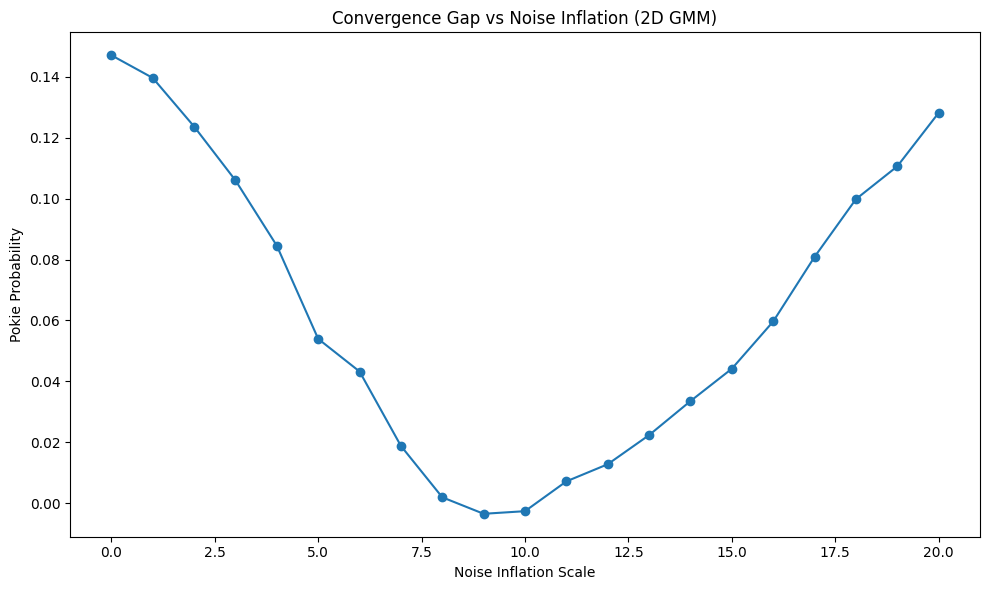

E[lambda]: 0.4979921877384186
E[lambda^2]: 0.33137378096580505


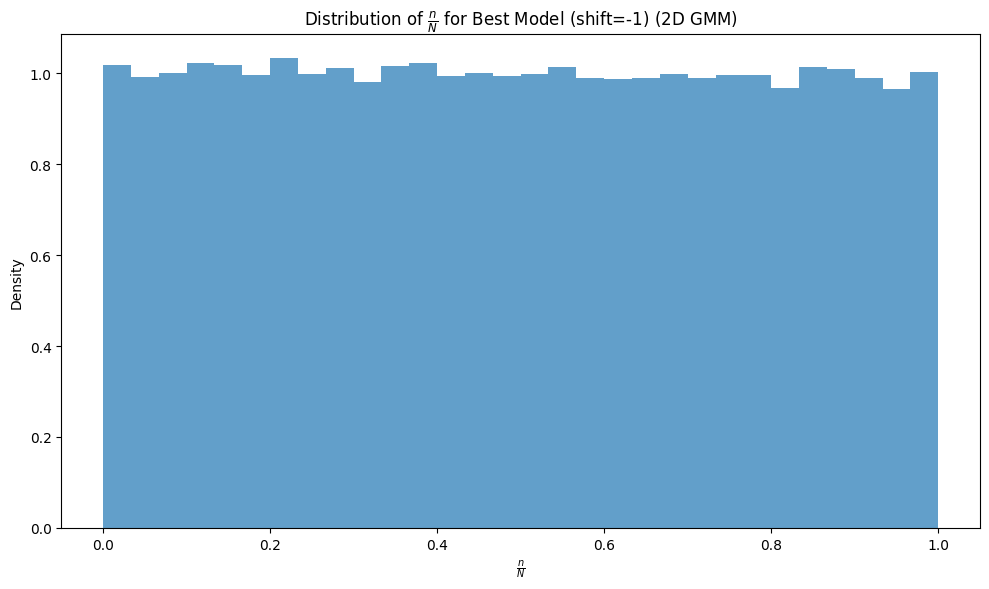

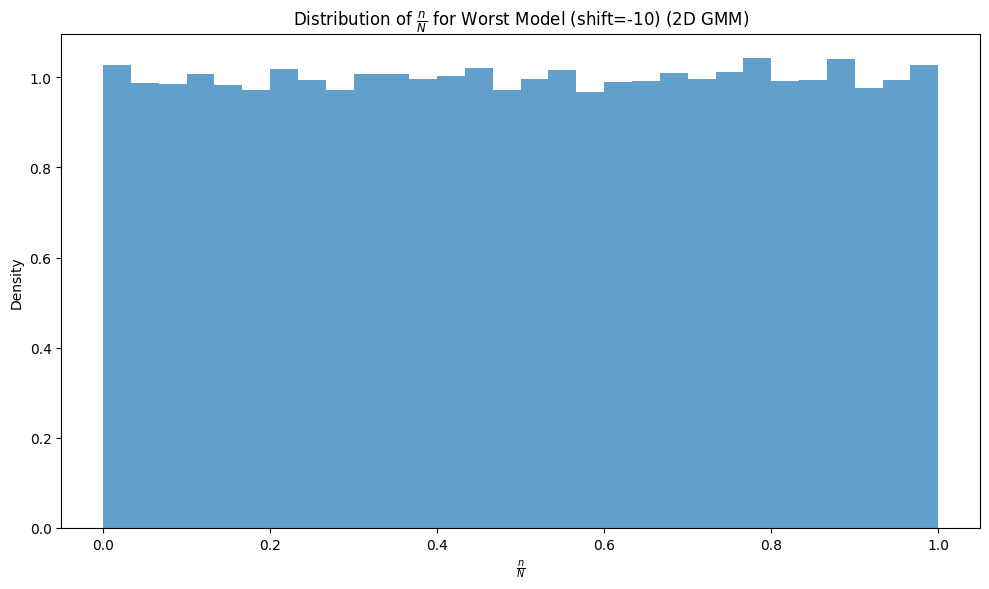

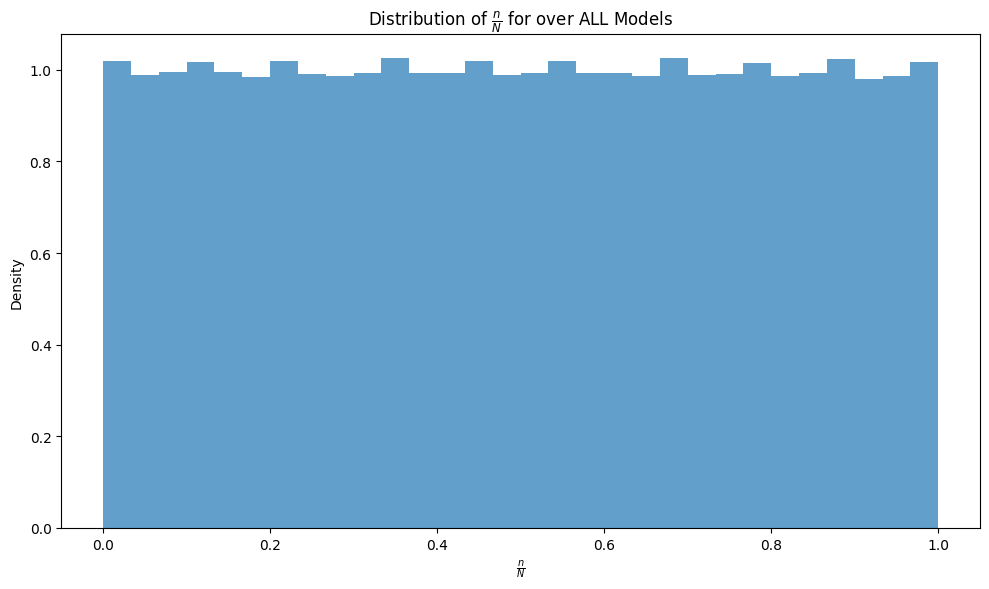

In [ ]:
# Identify your device (CUDA > MPS > CPU)
device = get_device()
print("Using device:", device)

out = pokie_with_convergence_estimate(truth_data_normalized, models_normalized, num_runs=curr_num_runs)

l_values = np.linspace(0, len(results) - 1, len(results))
l_values = np.array(l_values)

emperical_pokie = out['empirical_pokie'].cpu().numpy()
theoretical_pokie = out['theoretical_pokie'].cpu().numpy()
convergence_gap = out['convergence_gap'].cpu().numpy()
E_lambda = out['E_lambda'].cpu().numpy()
E_lambda_sq = out['E_lambda_sq'].cpu().numpy()
n_over_N_vals = out['n_over_N_vals'].cpu().numpy()

print('\Modes:', l_values)
print('Emperical Pokie:', emperical_pokie)
print('Theoretical Pokie:', theoretical_pokie)
print('Convergence Gap:', convergence_gap)

plt.figure(figsize=(10, 6))
plt.plot(l_values, convergence_gap, marker='o')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Convergence Gap vs Noise Inflation (2D GMM)')
plt.tight_layout()
plt.savefig(f"../PLots/GMM/2D/Num_Runs_{curr_num_runs}/Pokie_Convergence_Gap_2D_GMM_Num_Runs_{curr_num_runs}.pdf")
plt.show()

# Identify the best model
best_model_idx = np.argmin(convergence_gap)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
best_vals = n_over_N_vals[:, best_model_idx, :].reshape(-1)

print("E[lambda]:", out["E_lambda"][best_model_idx].item())
print("E[lambda^2]:", out["E_lambda_sq"][best_model_idx].item())

# Plot the distribution of n/N values for the best model
plt.figure(figsize=(10, 6))
plt.hist(best_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Best Model (shift={shift_magnitudes[best_model_idx]}) (2D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig(f"../PLots/GMM/2D/Num_Runs_{curr_num_runs}/Pokie_Convergence_Best_Model_n_over_N_Lensed_Images_Num_Runs_{curr_num_runs}.pdf")
plt.show()

# Identify the Worst Model
worst_model_idx = np.argmax(convergence_gap)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
worst_vals = n_over_N_vals[:, worst_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(worst_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Worst Model (shift={shift_magnitudes[worst_model_idx]}) (2D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig(f"../PLots/GMM/2D/Num_Runs_{curr_num_runs}/Pokie_Convergence_Worst_Model_n_over_N_Lensed_Images_Num_Runs_{curr_num_runs}.pdf")
plt.show()

# Concat all n/N values across all models
all_vals = n_over_N_vals.reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(all_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for over ALL Models")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig(f"../PLots/GMM/2D/Num_Runs_{curr_num_runs}/Pokie_Convergence_n_over_N_Lensed_Images_Num_Runs_{curr_num_runs}.pdf")
plt.show()

# 20 Dimensions

In [9]:
# Set up the GMM parameters
n_components = 20
n_dimensions = 10
n_truth_samples = 500  # Number of ground truth samples
num_posterior_samples = 500  # Number of posterior samples per truth
epsilon = 1e-3  # Small value to avoid division by zero

# Initialize random means and covariances for the GMM components
means = np.random.rand(n_components, n_dimensions) * 10  # Random means between 0 and 10
covariances = np.random.rand(n_components, n_dimensions) + epsilon  # Ensure strictly positive variance

# Generate the truth data (no shift)
truth_data = generate_samples_from_gmm(means, covariances, n_truth_samples)

# Generate the models with different shift magnitudes from -10 to 10 along the diagonal
shift_magnitudes = np.arange(-10, 11, 1)  # Shift values from -10 to 10  # Shift values from -10 to 10
num_models = len(shift_magnitudes)

print(f'Shift magnitudes: {shift_magnitudes}')

# Generate shifted GMMs once per model
models_base = np.zeros((num_models, num_posterior_samples, n_dimensions))  # Shape: (21, 500, 2)

for i, shift in enumerate(tqdm(shift_magnitudes, desc=f'Generating Shifted GMMs')):
    models_base[i] = generate_samples_from_gmm(means, covariances, num_posterior_samples) + np.ones(n_dimensions) * shift

# Now, expand to (num_models, num_truth_samples, num_posterior_samples, dimensions)
models = np.repeat(models_base[:, np.newaxis, :, :], n_truth_samples, axis=1)

# Validate shape
assert models.shape == (num_models, n_truth_samples, num_posterior_samples, n_dimensions), "Shape mismatch!"

epsilon = 1e-10  # Small value to avoid division by zero

# Get min and max from truth_data (per dimension)
low = np.min(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)
high = np.max(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)

# Normalize truth_data
truth_data_normalized = (truth_data - low) / (high - low + epsilon)

# Normalize models (loop over each shift magnitude)
models_normalized = np.zeros_like(models)
for m_idx in range(num_models):
    models_normalized[m_idx] = (models[m_idx] - low) / (high - low + epsilon)

Shift magnitudes: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]


Generating Shifted GMMs: 100%|██████████| 21/21 [00:00<00:00, 73.11it/s]


In [10]:
# Identify your device (CUDA > MPS > CPU)
device = get_device()
print("Using device:", device)

# Convert to torch Tensors on the chosen device
truth_data_normalized   = torch.tensor(truth_data_normalized, dtype=torch.float32, device=device)
models_normalized = torch.tensor(models_normalized,   dtype=torch.float32, device=device)

results, calibrated, n_over_N_vals = pokie(truth_data_normalized, models_normalized, num_runs=curr_num_runs)

# Convert results, calibrated, n_over_N_vals back to numpy arrays
results = results.cpu().numpy()
calibrated = calibrated.cpu().numpy()
n_over_N_vals = n_over_N_vals.cpu().numpy()

print('\nShift Magnitudes:', shift_magnitudes)
print('Results:', results)
print('Calibrated:', calibrated)

Using device: mps


Pokie MC runs: 100%|██████████| 100/100 [00:00<00:00, 140.52it/s]



Shift Magnitudes: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]
Results: [0.04218641 0.04205585 0.04245965 0.04288024 0.04405398 0.04652391
 0.04904388 0.05226744 0.05480499 0.05560738 0.05622178 0.05600004
 0.05476823 0.05257384 0.04913485 0.04602106 0.04373429 0.04275118
 0.04256728 0.04230515 0.0420386 ]
Calibrated: [0.5012321  0.49968088 0.5044787  0.50947577 0.52342135 0.5527676
 0.5827083  0.6210087  0.6511581  0.6606916  0.66799146 0.6653569
 0.65072143 0.62464905 0.5837891  0.54679304 0.5196231  0.5079424
 0.50575745 0.502643   0.49947593]


# 20D GMM Plots

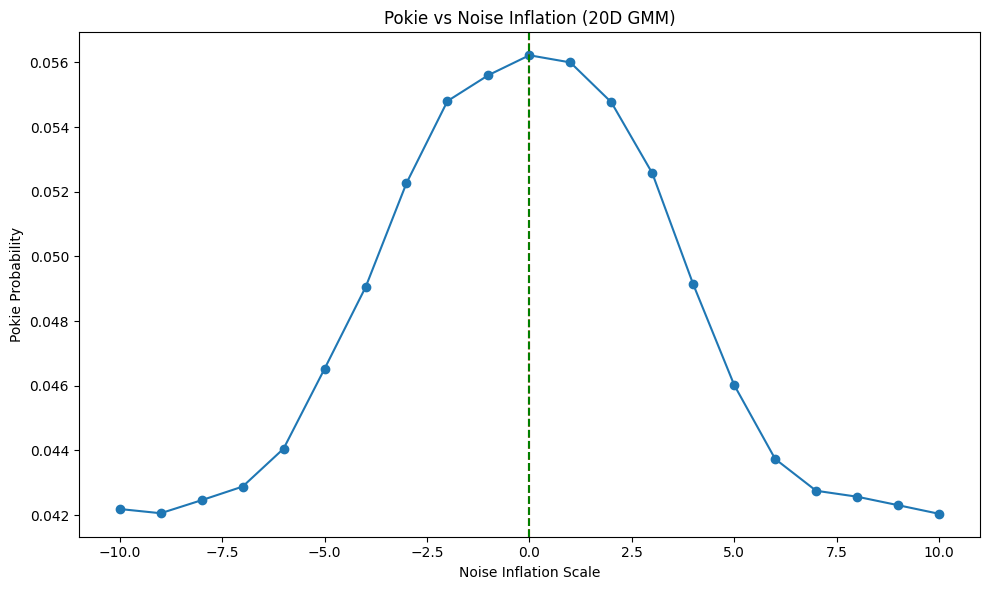

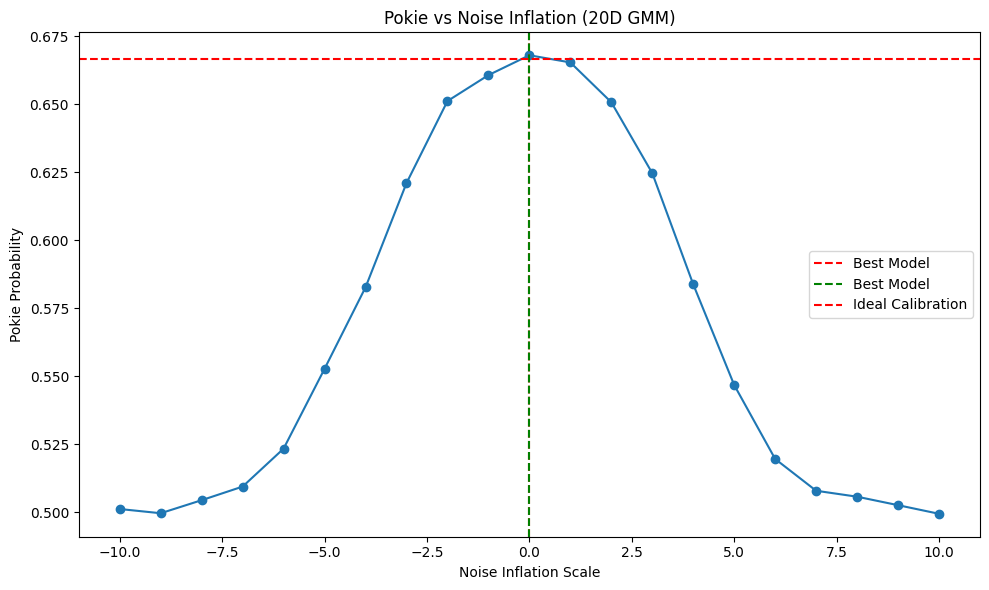

In [ ]:
# Print Index and Value of the best model (i.e. the one with the largest value in results)
best_model_idx = np.argmax(results)
best_model_value = results[best_model_idx]

# Plot Pokie vs noise level
plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, results, marker='o')
plt.axvline(x=0, color='r', linestyle='--', label='Best Model')
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--', label='Best Model')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Pokie vs Noise Inflation (20D GMM)')
plt.tight_layout()
plt.savefig(f"../PLots/GMM/20D/Num_Runs_{curr_num_runs}/Pokie_20D_GMM_Num_Runs_{curr_num_runs}.pdf")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, calibrated, marker='o')
plt.axvline(x=0, color='r', linestyle='--', label='Best Model')
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--', label='Best Model')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Pokie vs Noise Inflation (20D GMM)')
plt.axhline(y=2/3, color='r', linestyle='--', label='Ideal Calibration')
plt.legend()
plt.tight_layout()
plt.savefig(f"../PLots/GMM/20D/Num_Runs_{curr_num_runs}/Pokie_20D_GMM_Calibrated_Num_Runs_{curr_num_runs}.pdf")
plt.show()

# 20 Dimensional n/N Distribution Plots

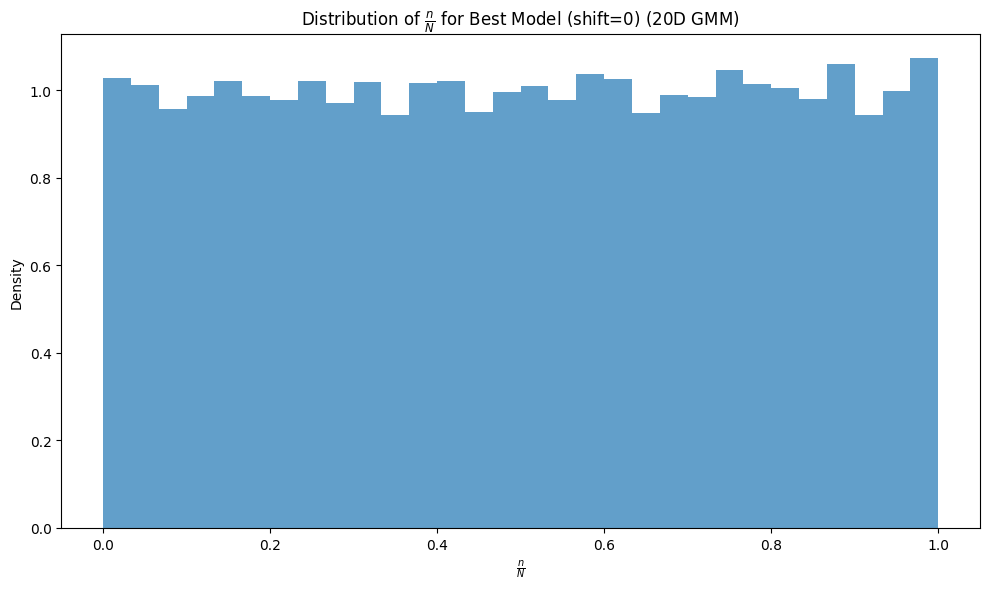

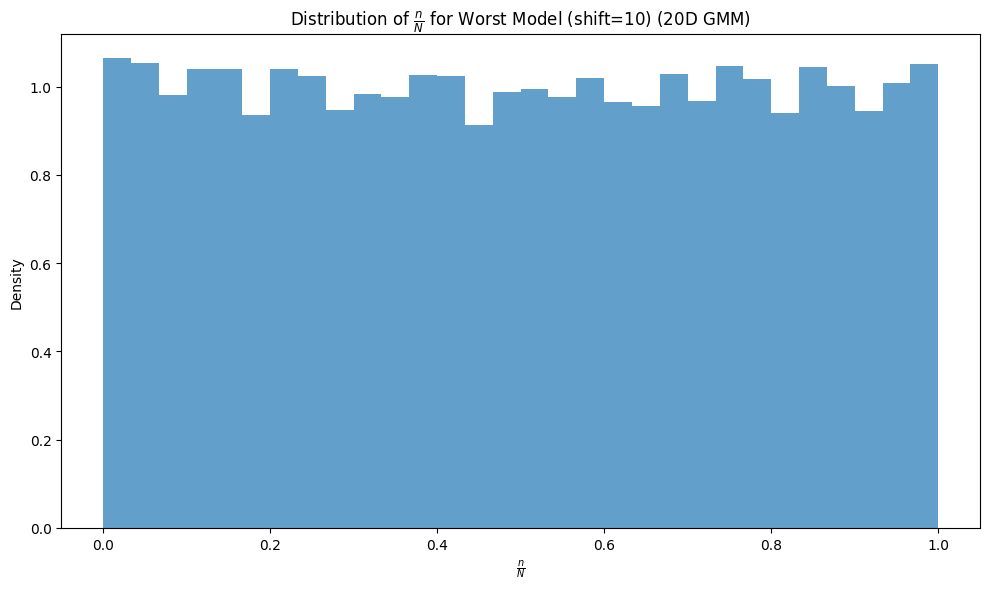

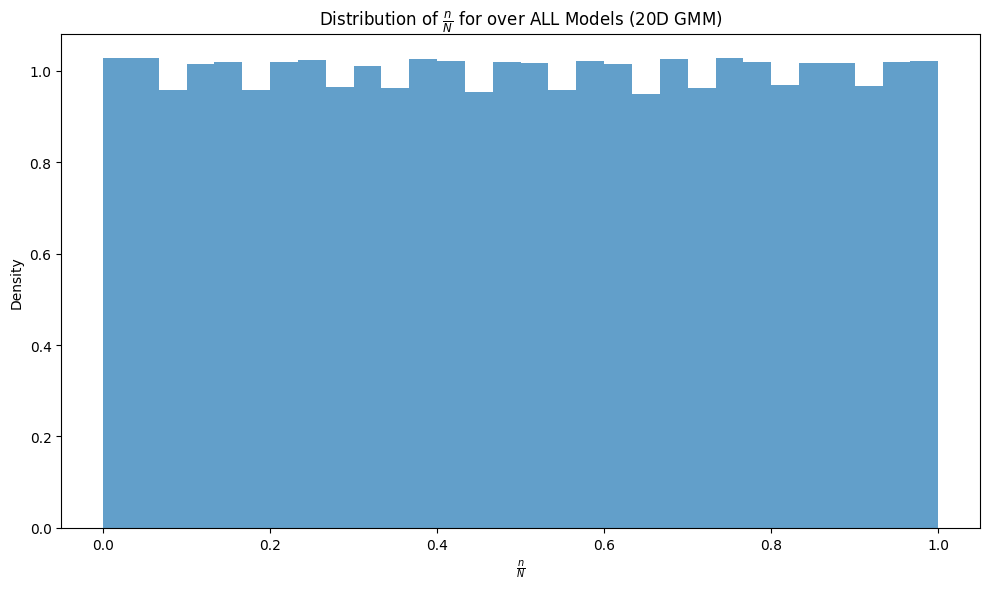

In [ ]:
# Identify the best model
best_model_idx = np.argmax(results)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
best_vals = n_over_N_vals[:, best_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the best model
plt.figure(figsize=(10, 6))
plt.hist(best_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Best Model (shift={shift_magnitudes[best_model_idx]}) (20D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig(f"../PLots/GMM/20D/Num_Runs_{curr_num_runs}/Pokie_Best_Model_n_over_N_20D_GMM_Num_Runs_{curr_num_runs}.pdf")
plt.show()

# Identify the Worst Model
worst_model_idx = np.argmin(results)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
worst_vals = n_over_N_vals[:, worst_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(worst_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Worst Model (shift={shift_magnitudes[worst_model_idx]}) (20D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig(f"../PLots/GMM/20D/Num_Runs_{curr_num_runs}/Pokie_Worst_Model_n_over_N_20D_GMM_Num_Runs_{curr_num_runs}.pdf")
plt.show()

# Concat all n/N values across all models
all_vals = n_over_N_vals.reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(all_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for over ALL Models (20D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig(f"../PLots/GMM/20D/Num_Runs_{curr_num_runs}/Pokie_n_over_N_20D_GMM_Num_Runs_{curr_num_runs}.pdf")
plt.show()

# 20D Convergence Test & Plots

Using device: mps


Pokie MC runs: 100%|██████████| 100/100 [00:00<00:00, 142.71it/s]


\Modes: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
Emperical Pokie: [0.04236135 0.04223745 0.04252613 0.04290147 0.04442232 0.04638168
 0.04874155 0.05214683 0.05478628 0.05575962 0.05619078 0.05579066
 0.05481332 0.05257713 0.04885791 0.04590416 0.04406578 0.04274371
 0.04244159 0.04214808 0.0422022 ]
Theoretical Pokie: [0.6676174  0.6649731  0.66647965 0.6660657  0.6674894  0.666054
 0.6668619  0.6660398  0.66707534 0.667607   0.66651255 0.6658839
 0.6667289  0.6671166  0.66675436 0.6665615  0.66628546 0.6662552
 0.6669897  0.66627675 0.6668058 ]
Convergence Gap: [ 0.16435093  0.16317862  0.16125548  0.15638244  0.13973796  0.11502475
  0.08779669  0.04651862  0.01619667  0.00516474 -0.00105202  0.00307298
  0.0155291   0.04248351  0.08630669  0.12120545  0.14276981  0.1584462
  0.16276991  0.1655441   0.16543013]


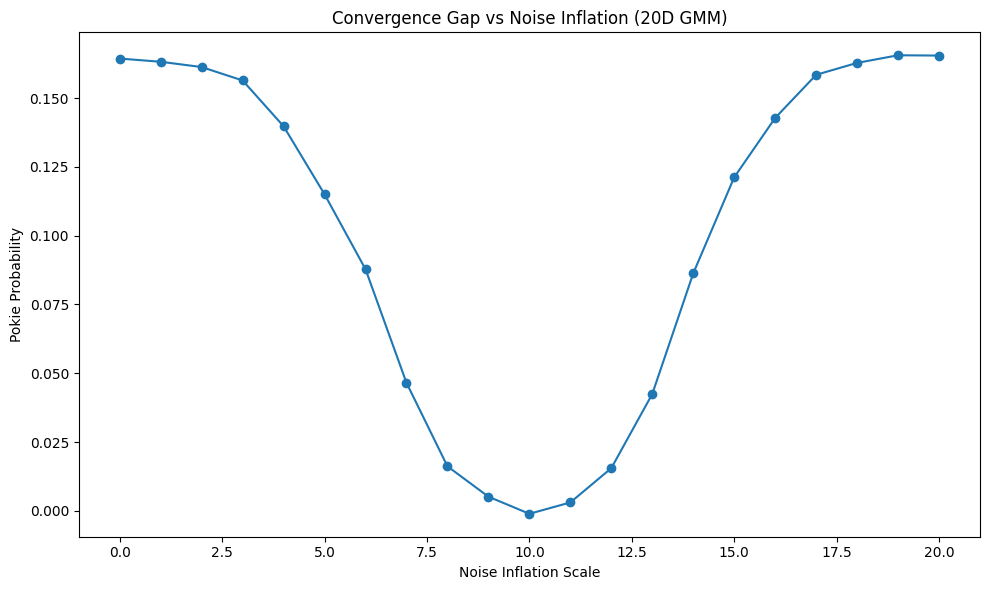

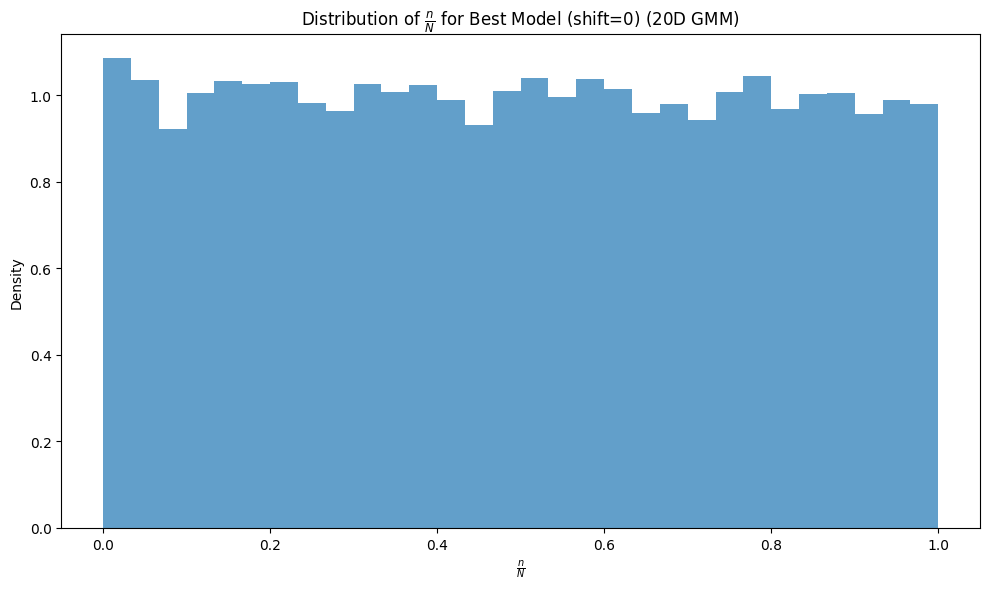

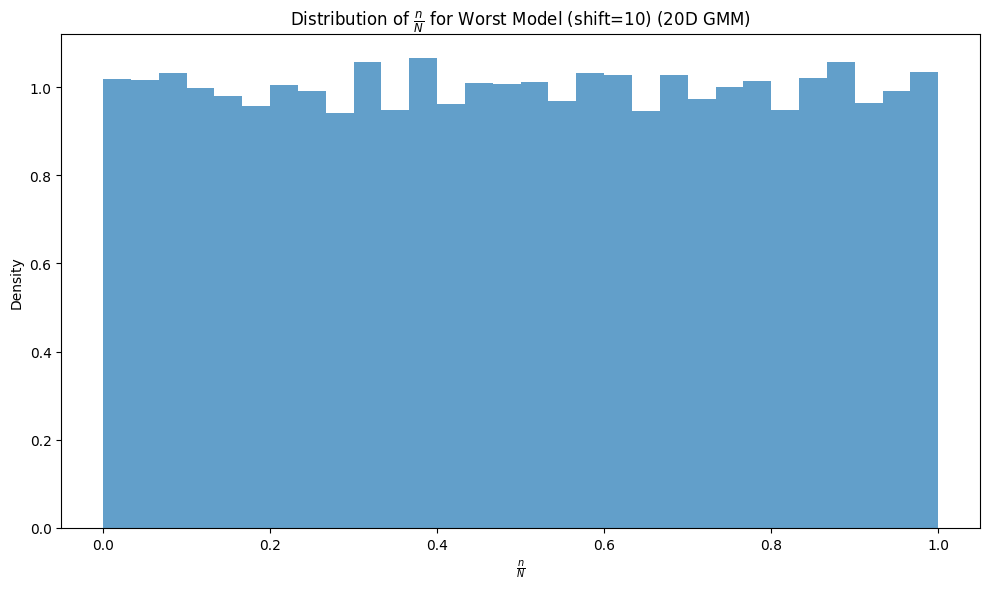

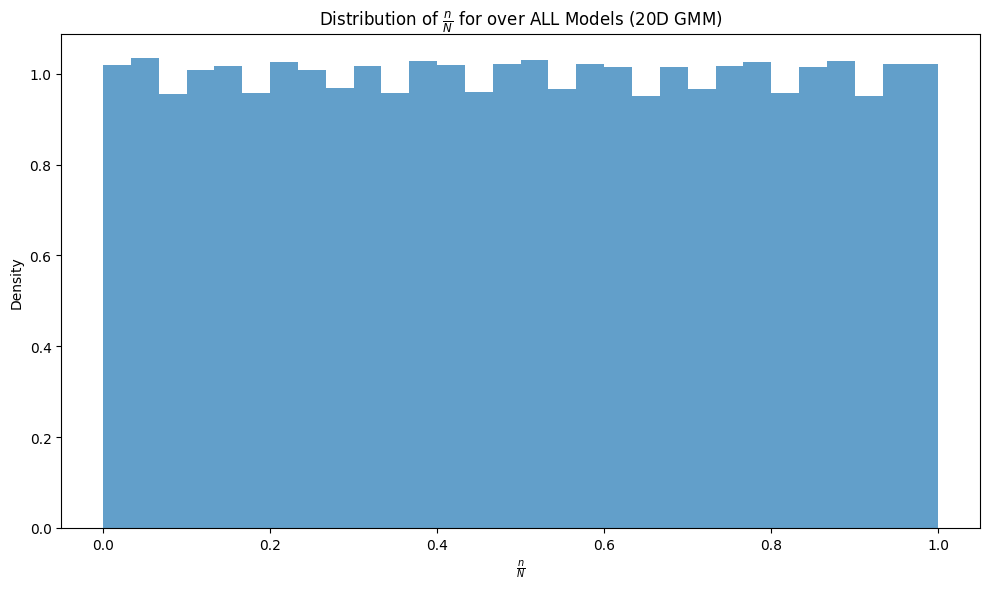

In [ ]:
# Identify your device (CUDA > MPS > CPU)
device = get_device()
print("Using device:", device)

out = pokie_with_convergence_estimate(truth_data_normalized, models_normalized, num_runs=curr_num_runs)

l_values = np.linspace(0, len(results) - 1, len(results))
l_values = np.array(l_values)

emperical_pokie = out['empirical_pokie'].cpu().numpy()
theoretical_pokie = out['theoretical_pokie'].cpu().numpy()
convergence_gap = out['convergence_gap'].cpu().numpy()
E_lambda = out['E_lambda'].cpu().numpy()
E_lambda_sq = out['E_lambda_sq'].cpu().numpy()
n_over_N_vals = out['n_over_N_vals'].cpu().numpy()

print('\Modes:', l_values)
print('Emperical Pokie:', emperical_pokie)
print('Theoretical Pokie:', theoretical_pokie)
print('Convergence Gap:', convergence_gap)

plt.figure(figsize=(10, 6))
plt.plot(l_values, convergence_gap, marker='o')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Convergence Gap vs Noise Inflation (20D GMM)')
plt.tight_layout()
plt.savefig(f"../PLots/GMM/20D/Num_Runs_{curr_num_runs}/Pokie_Convergence_Gap_20D_GMM_Num_Runs_{curr_num_runs}.pdf")
plt.show()

# Identify the best model
best_model_idx = np.argmax(results)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
best_vals = n_over_N_vals[:, best_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the best model
plt.figure(figsize=(10, 6))
plt.hist(best_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Best Model (shift={shift_magnitudes[best_model_idx]}) (20D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig(f"../PLots/GMM/20D/Num_Runs_{curr_num_runs}/Pokie_Best_Model_n_over_N_20D_GMM_Num_Runs_{curr_num_runs}.pdf")
plt.show()

# Identify the Worst Model
worst_model_idx = np.argmin(results)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
worst_vals = n_over_N_vals[:, worst_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(worst_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Worst Model (shift={shift_magnitudes[worst_model_idx]}) (20D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig(f"../PLots/GMM/20D/Num_Runs_{curr_num_runs}/Pokie_Worst_Model_n_over_N_20D_GMM_Num_Runs_{curr_num_runs}.pdf")
plt.show()

# Concat all n/N values across all models
all_vals = n_over_N_vals.reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(all_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for over ALL Models (20D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig(f"../PLots/GMM/20D/Num_Runs_{curr_num_runs}/Pokie_Convergence_n_over_N_20D_GMM_Num_Runs_{curr_num_runs}.pdf")
plt.show()

# 100 Dimension

In [14]:
# Set up the GMM parameters
n_components = 20
n_dimensions = 100
n_truth_samples = 500  # Number of ground truth samples
num_posterior_samples = 500  # Number of posterior samples per truth
epsilon = 1e-3  # Small value to avoid division by zero

# Initialize random means and covariances for the GMM components
means = np.random.rand(n_components, n_dimensions) * 10  # Random means between 0 and 10
covariances = np.random.rand(n_components, n_dimensions) + epsilon  # Ensure strictly positive variance

# Generate the truth data (no shift)
truth_data = generate_samples_from_gmm(means, covariances, n_truth_samples)

# Generate the models with different shift magnitudes from -10 to 10 along the diagonal
shift_magnitudes = np.arange(-10, 11, 1)  # Shift values from -10 to 10  # Shift values from -10 to 10
num_models = len(shift_magnitudes)

print(f'Shift magnitudes: {shift_magnitudes}')

# Generate shifted GMMs once per model
models_base = np.zeros((num_models, num_posterior_samples, n_dimensions))  # Shape: (21, 500, 2)

for i, shift in enumerate(tqdm(shift_magnitudes, desc=f'Generating Shifted GMMs')):
    models_base[i] = generate_samples_from_gmm(means, covariances, num_posterior_samples) + np.ones(n_dimensions) * shift

# Now, expand to (num_models, num_truth_samples, num_posterior_samples, dimensions)
models = np.repeat(models_base[:, np.newaxis, :, :], n_truth_samples, axis=1)

# Validate shape
assert models.shape == (num_models, n_truth_samples, num_posterior_samples, n_dimensions), "Shape mismatch!"

epsilon = 1e-10  # Small value to avoid division by zero

# Get min and max from truth_data (per dimension)
low = np.min(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)
high = np.max(truth_data, axis=0, keepdims=True)  # Shape: (1, n_dimensions)

# Normalize truth_data
truth_data_normalized = (truth_data - low) / (high - low + epsilon)

# Normalize models (loop over each shift magnitude)
models_normalized = np.zeros_like(models)
for m_idx in range(num_models):
    models_normalized[m_idx] = (models[m_idx] - low) / (high - low + epsilon)

Shift magnitudes: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]


Generating Shifted GMMs: 100%|██████████| 21/21 [00:10<00:00,  1.92it/s]


In [15]:
# Identify your device (CUDA > MPS > CPU)
device = get_device()
print("Using device:", device)

# Convert to torch Tensors on the chosen device
truth_data_normalized   = torch.tensor(truth_data_normalized, dtype=torch.float32, device=device)
models_normalized = torch.tensor(models_normalized,   dtype=torch.float32, device=device)

results, calibrated, n_over_N_vals = pokie(truth_data_normalized, models_normalized, num_runs=curr_num_runs)

# Convert results, calibrated, n_over_N_vals back to numpy arrays
results = results.cpu().numpy()
calibrated = calibrated.cpu().numpy()
n_over_N_vals = n_over_N_vals.cpu().numpy()

print('\nShift Magnitudes:', shift_magnitudes)
print('Results:', results)
print('Calibrated:', calibrated)

Using device: mps


Pokie MC runs: 100%|██████████| 100/100 [20:05<00:00, 12.05s/it]



Shift Magnitudes: [-10  -9  -8  -7  -6  -5  -4  -3  -2  -1   0   1   2   3   4   5   6   7
   8   9  10]
Results: [0.04469168 0.04487829 0.04473491 0.04481217 0.04494474 0.04486854
 0.04480508 0.04578929 0.05250754 0.05909402 0.05964287 0.05864093
 0.05128516 0.04553109 0.04487234 0.0448153  0.04495439 0.04472105
 0.04474845 0.04481611 0.04484601]
Calibrated: [0.4995046  0.50159013 0.49998763 0.5008513  0.502333   0.50148124
 0.500772   0.51177216 0.5868599  0.660475   0.6666091  0.655411
 0.5731977  0.5088864  0.50152373 0.5008862  0.50244075 0.49983284
 0.50013906 0.50089526 0.5012294 ]


# 100D GMM Plots

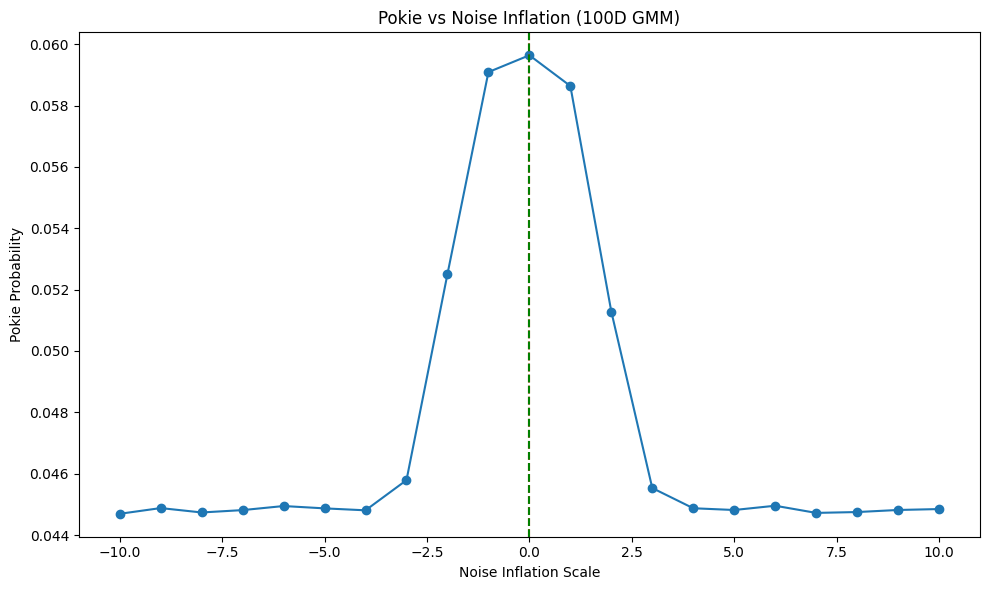

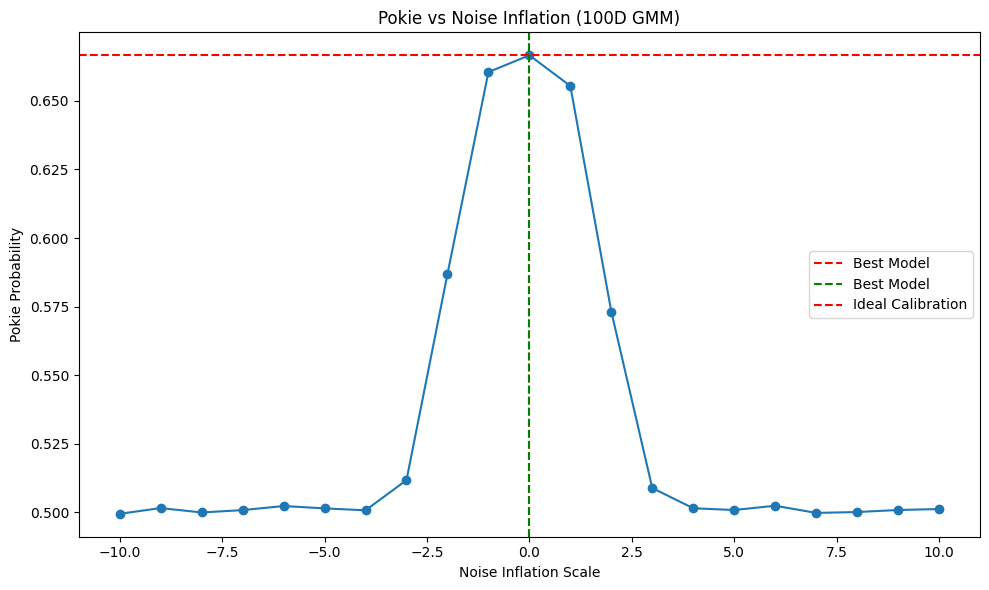

In [ ]:
# Print Index and Value of the best model (i.e. the one with the largest value in results)
best_model_idx = np.argmax(results)
best_model_value = results[best_model_idx]

# Plot Pokie vs noise level
plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, results, marker='o')
plt.axvline(x=0, color='r', linestyle='--', label='Best Model')
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--', label='Best Model')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Pokie vs Noise Inflation (100D GMM)')
plt.tight_layout()
plt.savefig(f"../PLots/GMM/100D/Num_Runs_{curr_num_runs}/Pokie_100D_GMM_Num_Runs_{curr_num_runs}.pdf")
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(shift_magnitudes, calibrated, marker='o')
plt.axvline(x=0, color='r', linestyle='--', label='Best Model')
plt.axvline(x=shift_magnitudes[best_model_idx], color='g', linestyle='--', label='Best Model')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Pokie vs Noise Inflation (100D GMM)')
plt.axhline(y=2/3, color='r', linestyle='--', label='Ideal Calibration')
plt.legend()
plt.tight_layout()
plt.savefig(f"../PLots/GMM/100D/Num_Runs_{curr_num_runs}/Pokie_100D_GMM_Calibrated_Num_Runs_{curr_num_runs}.pdf")
plt.show()

# 100 Dimensional n/N Distribution Plots

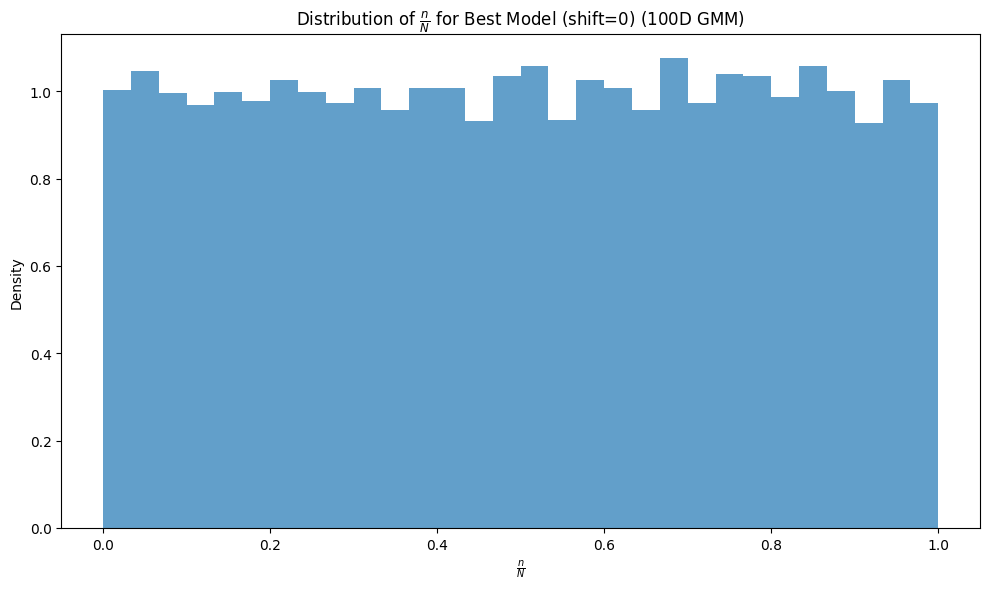

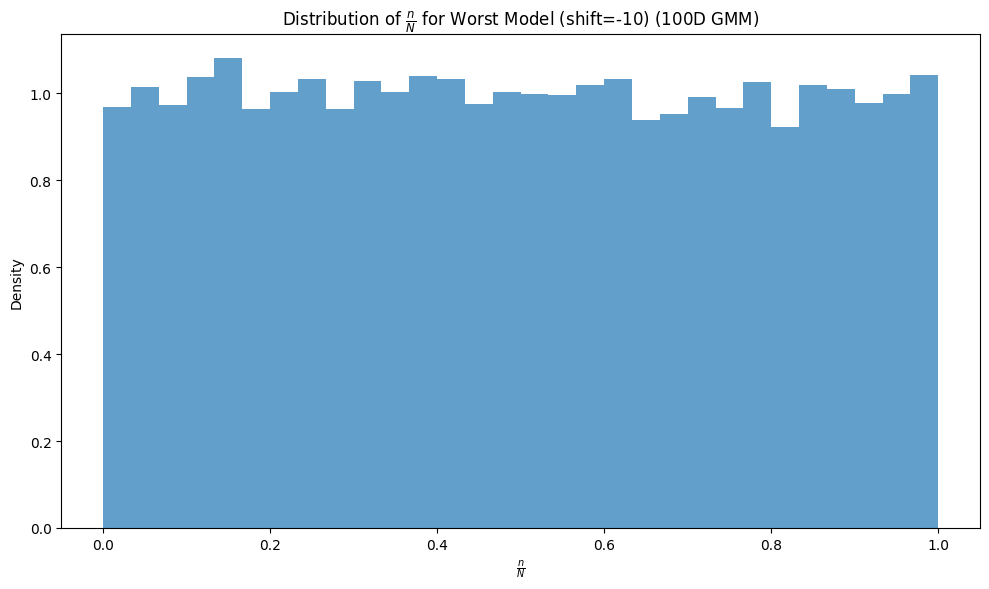

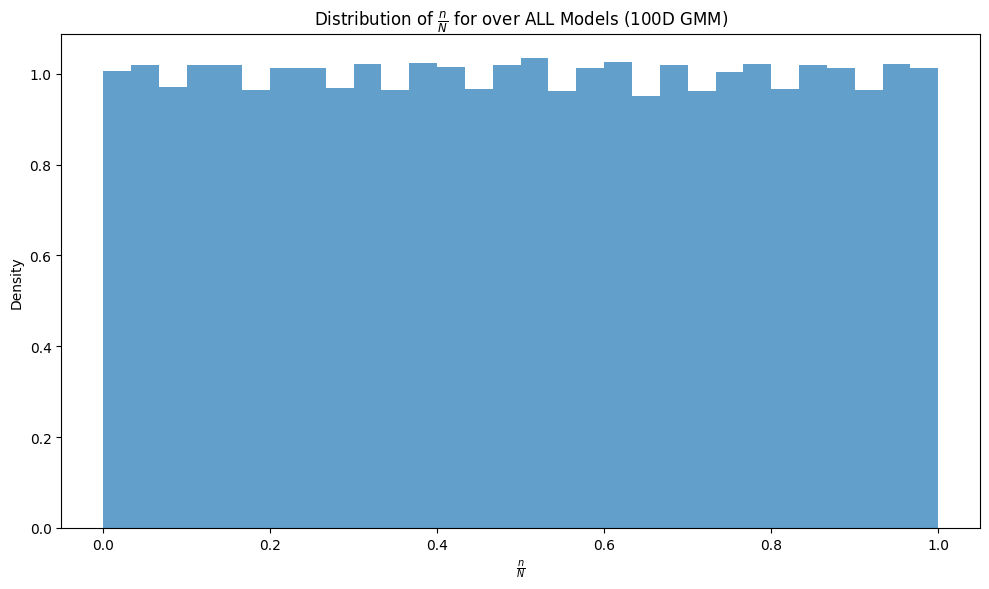

In [ ]:
# Identify the best model
best_model_idx = np.argmax(results)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
best_vals = n_over_N_vals[:, best_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the best model
plt.figure(figsize=(10, 6))
plt.hist(best_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Best Model (shift={shift_magnitudes[best_model_idx]}) (100D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig(f"../PLots/GMM/100D/Num_Runs_{curr_num_runs}/Pokie_Best_Model_n_over_N_100D_GMM_Num_Runs_{curr_num_runs}.pdf")
plt.show()

# Identify the Worst Model
worst_model_idx = np.argmin(results)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
worst_vals = n_over_N_vals[:, worst_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(worst_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Worst Model (shift={shift_magnitudes[worst_model_idx]}) (100D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig(f"../PLots/GMM/100D/Num_Runs_{curr_num_runs}/Pokie_Worst_Model_n_over_N_100D_GMM_Num_Runs_{curr_num_runs}.pdf")
plt.show()

# Concat all n/N values across all models
all_vals = n_over_N_vals.reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(all_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for over ALL Models (100D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig(f"../PLots/GMM/100D/Num_Runs_{curr_num_runs}/Pokie_n_over_N_100D_GMM_Num_Runs_{curr_num_runs}.pdf")
plt.show()

# 100D Convergence Test & Plots

Using device: mps


Pokie MC runs: 100%|██████████| 100/100 [18:08<00:00, 10.89s/it]


\Modes: [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20.]
Emperical Pokie: [0.04450735 0.04477219 0.04478447 0.04497097 0.04467605 0.04487165
 0.04487186 0.0459479  0.05257011 0.05897294 0.05970971 0.05851871
 0.05165349 0.04555518 0.04483213 0.04476697 0.0448361  0.04476734
 0.04482271 0.04465658 0.04493558]
Theoretical Pokie: [0.6663676  0.6662124  0.6665988  0.6667542  0.6662623  0.6666583
 0.6663229  0.6676521  0.66666317 0.66664016 0.6673776  0.66652226
 0.6669556  0.66593826 0.666883   0.6661252  0.668383   0.66702694
 0.6661536  0.6667102  0.6675668 ]
Convergence Gap: [ 0.16849515  0.16537744  0.1656264   0.16369545  0.16650274  0.16471064
  0.16437298  0.15366524  0.07859838  0.00695145 -0.00055295  0.01191455
  0.08914429  0.15634447  0.1653775   0.16534859  0.16683304  0.16624624
  0.1647535   0.16716841  0.16490406]


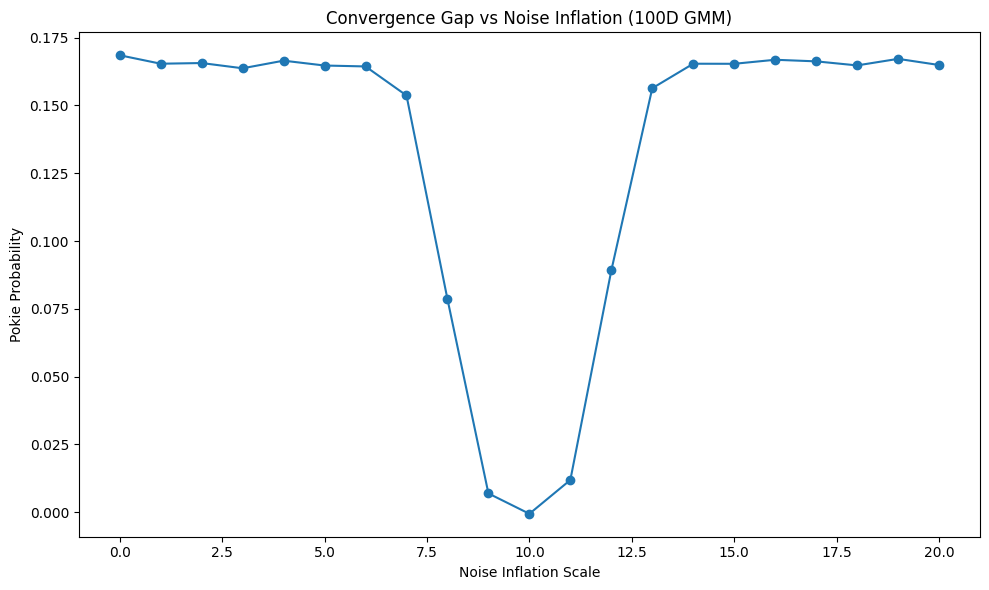

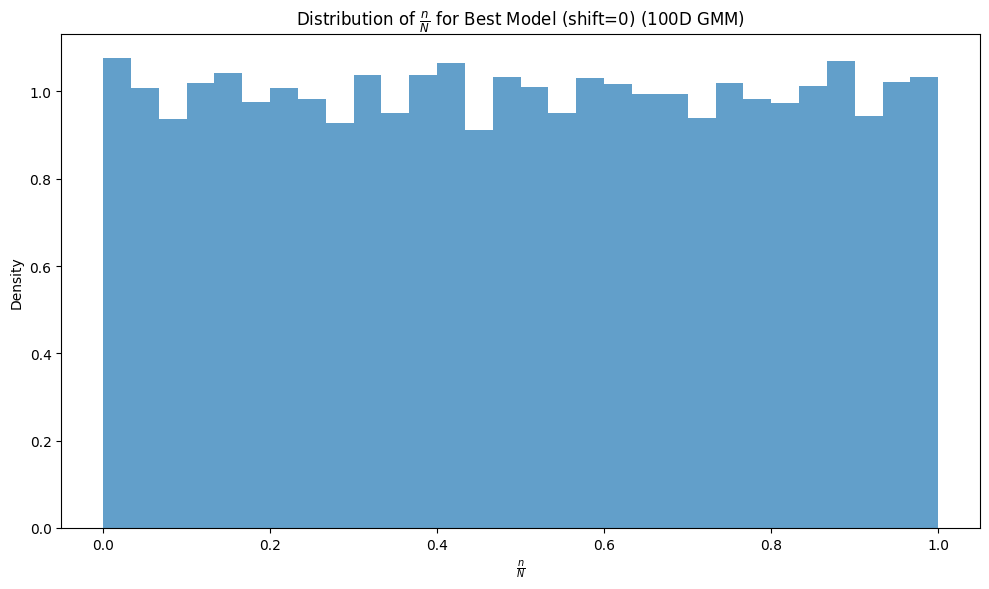

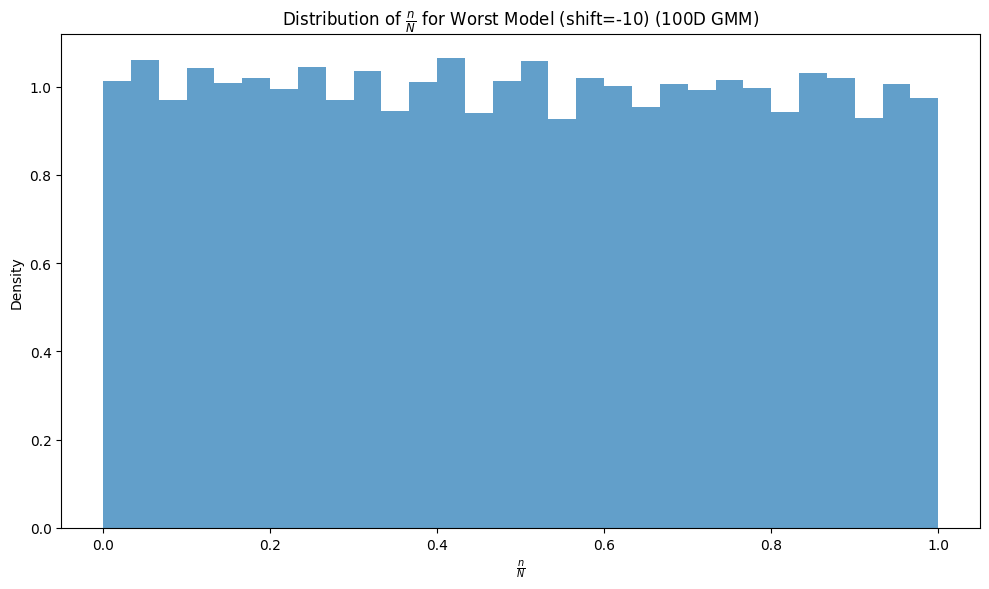

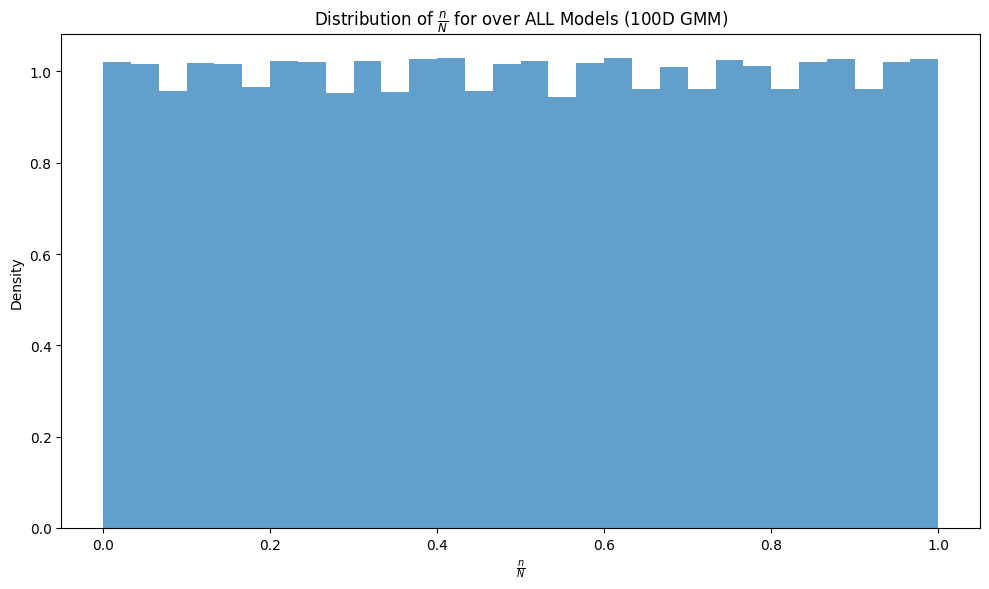

In [ ]:
# Identify your device (CUDA > MPS > CPU)
device = get_device()
print("Using device:", device)

out = pokie_with_convergence_estimate(truth_data_normalized, models_normalized, num_runs=curr_num_runs)

l_values = np.linspace(0, len(results) - 1, len(results))
l_values = np.array(l_values)

emperical_pokie = out['empirical_pokie'].cpu().numpy()
theoretical_pokie = out['theoretical_pokie'].cpu().numpy()
convergence_gap = out['convergence_gap'].cpu().numpy()
E_lambda = out['E_lambda'].cpu().numpy()
E_lambda_sq = out['E_lambda_sq'].cpu().numpy()
n_over_N_vals = out['n_over_N_vals'].cpu().numpy()

print('\Modes:', l_values)
print('Emperical Pokie:', emperical_pokie)
print('Theoretical Pokie:', theoretical_pokie)
print('Convergence Gap:', convergence_gap)

plt.figure(figsize=(10, 6))
plt.plot(l_values, convergence_gap, marker='o')
plt.xlabel('Noise Inflation Scale')
plt.ylabel('Pokie Probability')
plt.title('Convergence Gap vs Noise Inflation (100D GMM)')
plt.tight_layout()
plt.savefig(f"../PLots/GMM/100D/Num_Runs_{curr_num_runs}/Pokie_Convergence_Gap_100D_GMM_Num_Runs_{curr_num_runs}.pdf")
plt.show()

# Identify the best model
best_model_idx = np.argmax(results)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
best_vals = n_over_N_vals[:, best_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the best model
plt.figure(figsize=(10, 6))
plt.hist(best_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Best Model (shift={shift_magnitudes[best_model_idx]}) (100D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig(f"../PLots/GMM/100D/Num_Runs_{curr_num_runs}/Pokie_Best_Model_n_over_N_100D_GMM_Num_Runs_{curr_num_runs}.pdf")
plt.show()

# Identify the Worst Model
worst_model_idx = np.argmin(results)

# Extract its n/N values across all runs and all truths, then flatten
# n_over_N_vals has shape (n_runs, n_models, n_truths)
worst_vals = n_over_N_vals[:, worst_model_idx, :].reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(worst_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for Worst Model (shift={shift_magnitudes[worst_model_idx]}) (100D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig(f"../PLots/GMM/100D/Num_Runs_{curr_num_runs}/Pokie_Worst_Model_n_over_N_100D_GMM_Num_Runs_{curr_num_runs}.pdf")
plt.show()

# Concat all n/N values across all models
all_vals = n_over_N_vals.reshape(-1)

# Plot the distribution of n/N values for the worst model
plt.figure(figsize=(10, 6))
plt.hist(all_vals, bins=30, density=True, alpha=0.7)
plt.title(rf"Distribution of $\frac{{n}}{{N}}$ for over ALL Models (100D GMM)")
plt.xlabel(r"$\frac{n}{N}$")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig(f"../PLots/GMM/100D/Num_Runs_{curr_num_runs}/Pokie_Convergence_n_over_N_100D_GMM_Num_Runs_{curr_num_runs}.pdf")
plt.show()